# CS5841 Classification Project 1
## Wei Qian, Zhiyuan Lu

Download the MNIST data set, load the training image, training label, testing image, and testing label. Read the file information and decode the image file into pixel data, label file into real number.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import struct
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def decode_idx3_ubyte(filename):
    bin_data = open(filename, 'rb').read()
 
    # decode header info
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, image number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
 
    # decode dataset
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images
 
def decode_idx1_ubyte(filename):
    bin_data = open(filename, 'rb').read()
 
    # decode header info
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, image number: %d' % (magic_number, num_images))
 
    # decode dataset
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

if __name__ == '__main__':
    train_image = decode_idx3_ubyte('train-images-idx3-ubyte')
    train_label = decode_idx1_ubyte('train-labels-idx1-ubyte')
    test_image = decode_idx3_ubyte('t10k-images-idx3-ubyte')
    test_label = decode_idx1_ubyte('t10k-labels-idx1-ubyte')
    
    m=60000
    trainX = np.zeros((m, 784)) # set a matrix 60000*784
    for i in range(m):
        for j in range(28):
            for k in range(28):
                trainX[i, 28*j+k] = train_image[i][j][k]
    
    mt=10000
    testX = np.zeros((mt, 784)) # set a matrix 60000*784
    for i in range(mt):
        for j in range(28):
            for k in range(28):
                testX[i, 28*j+k] = test_image[i][j][k]
                
    print("Decode and transfer done!")

magic number:2051, image number: 60000, image size: 28*28
magic number:2049, image number: 60000
magic number:2051, image number: 10000, image size: 28*28
magic number:2049, image number: 10000
Decode and transfer done!


 ---
i)  Implement a 1-nearest neighbor classifier that considers the image pixels to be one long feature vector. We use sklearn KNighborsClassifier function to do it.
- Select 60000 for training data, 10000 for testing data
- Set n_neighbors=1 for KNighborsClassifier function
- Fit trainging data of x and traing data of y
- Predict the result for the testing data of x
- Count each number of digit occuring in the testing data and compare the prediction with these digits
- Compute the testing error and polt in a table

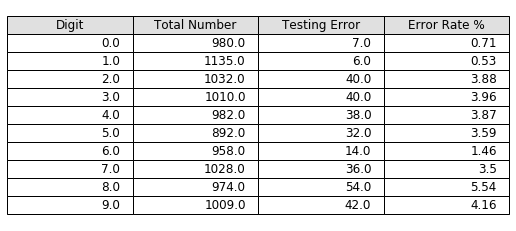

In [2]:
    x_train,y_train,x_test,y_test=trainX,train_label,testX,test_label
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    knn_clf.fit(x_train,y_train)
    
    y_pred=knn_clf.predict(x_test)
    
    digit=np.zeros(shape=(10,4)) # set a matrix 10*4, each column represents the digit, total, error, rate
    for i in range(digit.shape[0]): # initialize digit 
        digit[i][0]=i
 
    for i in range(y_test.shape[0]):
        digit[int(y_test[i])][1]+=1
        if y_test[i]!=y_pred[i]: # compare the test result with prediction result
            digit[int(y_test[i])][2]+=1
            
    for i in range(digit.shape[0]): # compute error rate
        if int(digit[i][1])!=0:
            digit[i][3]=int(digit[i][2])/int(digit[i][1])*100
    
    digit[:,3]=np.around(digit[:,3], decimals=2) # set precision of rate
    #print(digit)
    
    ax=plt.subplot()
    columns=('Digit','Total Number','Testing Error','Error Rate %')
    color=("#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0")
    table=ax.table(cellText=digit,colLabels=columns,loc='center',colColours=color)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax.axis("off")
    plt.show()


The following table shows the test results of implementing a 1-nearest neighbor classifier on the MNIST dataset. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100.

---
ii) Implement a KNN leave-one-out approach and test values of K from 1 to 20. We use sklearm LeaveOneOut and KNeighborsClassifier functions to do this.
 - Initialize a matrix to record error for each k and each digit
 - Run KNeighborsClassifier for k from 1 to 20, count the error for all digits
 - In every k, split one from dataset as testing data and the rest as training data
 - Compare all the errors for all digits and find the best value of k
 - Plot both the error results for all the digits and best valu of k for each digit

Randomly sample the training set:

In [3]:
    sampleX=np.empty(shape=(0,28*28))
    sampleY=np.array([])
    n=500 # random sample size
    for i in np.random.choice(m, n, replace=False):
        sampleX=np.append(sampleX, [trainX[i]], axis=0)
        sampleY=np.append(sampleY, train_label[i])
    
    print("Sample Done!")

Sample Done!


Training sample size: 500
Leave-one-out error:


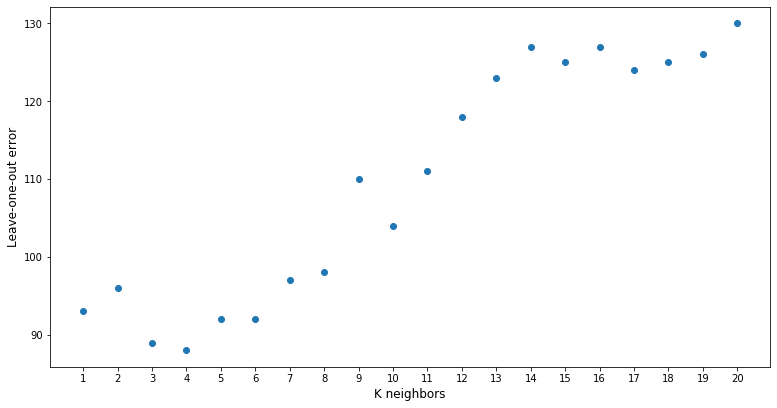

Best K: 4
Testing error for each digit:


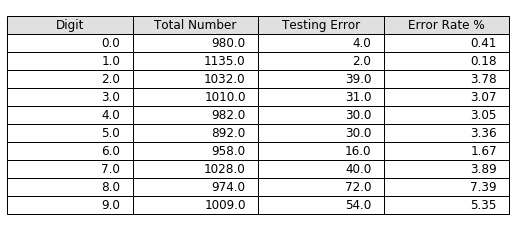

In [4]:
def knn_leave_one_out(X,Y):
    digit=np.zeros(shape=(10,21)) # set a matrix 10*21, each column represents the digit, error of k=1, k=2, ..., best k
    for i in range(digit.shape[0]): # initialize digit 
        digit[i][0]=i

    error=np.array([]) # set a array for leave-one-out error
        
    # test values of k from 1 to 20
    for k in range(1,21):
        loo = LeaveOneOut() # sklearn leave-one-out function
        errK=0
        for train_index, test_index in loo.split(X):
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            
            knn_clf = KNeighborsClassifier(n_neighbors=k)
            knn_clf.fit(x_train,y_train)
            y_pred=knn_clf.predict(x_test)
        
            for i in range(y_test.shape[0]):
                if y_test[i]!=y_pred[i]:
                    errK+=1
                    digit[int(y_test[i])][k]+=1
        error=np.append(error,errK)
    
    '''
    for i in range(digit.shape[0]):
        bestK=-1
        minErr=m
        for j in range(1,digit.shape[1]-1):
            if digit[i][j]<minErr:
                minErr=digit[i][j]
                bestK=j
        digit[i][digit.shape[1]-1]=bestK
    
    '''
    print("Leave-one-out error:")
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_axes([0,0,1,1])
    x=np.arange(1,21,1)
    bx.scatter(x,error)
    bx.set_xticks(range(1,21))
    bx.set_xlabel('K neighbors',fontsize=12)
    bx.set_ylabel('Leave-one-out error',fontsize=12)
    plt.show()
    
    '''
    print("Testing error for each digit:")
    ax=plt.subplot()
    columns=('Digit','K=1','K=2','K=3','K=4','K=5','K=6','K=7','K=8','K=9','K=10','K=11','K=12','K=13','K=14','K=15','K=16','K=17','K=18','K=19','K=20',"Best K")
    color=("#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0")
    table=ax.table(cellText=digit,colLabels=columns,loc='center',colColours=color)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(3, 2)
    ax.axis("off")
    plt.show()
    '''
    
    bestK=np.argmin(error)+1 # get the best K
    print("Best K:", bestK)
    print("Testing error for each digit:")
    
    x_train,y_train,x_test,y_test=trainX,train_label,testX,test_label
    knn_clf = KNeighborsClassifier(n_neighbors=bestK)
    knn_clf.fit(x_train,y_train)
    
    y_pred=knn_clf.predict(x_test)
    
    digit=np.zeros(shape=(10,4)) # set a matrix 10*4, each column represents the digit, total, error, rate
    for i in range(digit.shape[0]): # initialize digit 
        digit[i][0]=i
 
    for i in range(y_test.shape[0]):
        digit[int(y_test[i])][1]+=1
        if y_test[i]!=y_pred[i]: # compare the test result with prediction result
            digit[int(y_test[i])][2]+=1
            
    for i in range(digit.shape[0]): # compute error rate
        if int(digit[i][1])!=0:
            digit[i][3]=int(digit[i][2])/int(digit[i][1])*100
    
    digit[:,3]=np.around(digit[:,3], decimals=2) # set precision of rate
    #print(digit)
    
    ax=plt.subplot()
    columns=('Digit','Total Number','Testing Error','Error Rate %')
    color=("#E0E0E0","#E0E0E0","#E0E0E0","#E0E0E0")
    table=ax.table(cellText=digit,colLabels=columns,loc='center',colColours=color)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax.axis("off")
    plt.show()

print("Training sample size:",n)
knn_leave_one_out(sampleX,sampleY)

The following figure shows the test result of a KNN leave-one-out approach with test values of K neighbors from 1 to 20 for all digits in a test case K. X-axis is the value of K, y-axis is the leave-one-error corresponding to the value of K. The leave-one-out error is actually equal to the sum of the test errors of all the digits. Then we can get the minimum error for our best K value, which is 4.

The table shows the test result of a KNN leave-one-out approach with best value of K. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100.

---
iii) Implement a function that downsamples the image by a factor of n. 
- Set downsample image factor
- For each image, select a random index in every in the interval and save to a new train matrix
- Run KNN leave-one-out experiment for each factor

Training sample size: 500
Downsample by a factor of 2
Leave-one-out error:


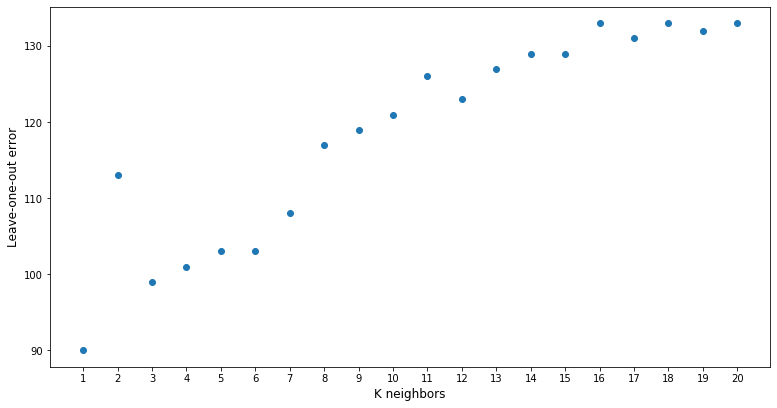

Best K: 1
Testing error for each digit:


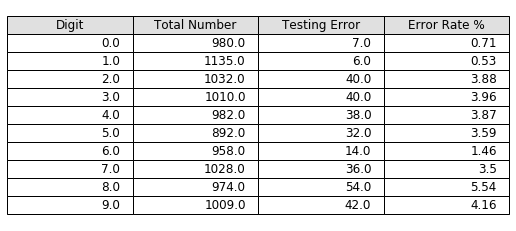

Query time: 748.3124120235443 

Downsample by a factor of 4
Leave-one-out error:


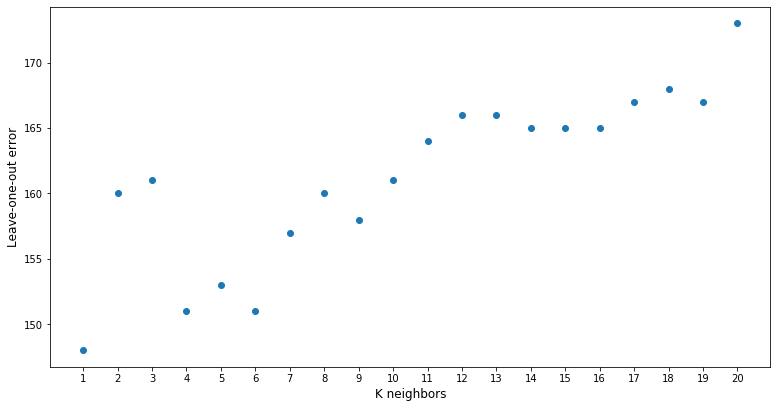

Best K: 1
Testing error for each digit:


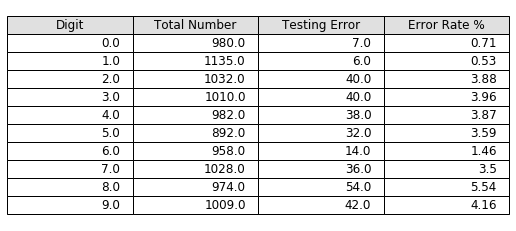

Query time: 734.8384160995483 

Downsample by a factor of 8
Leave-one-out error:


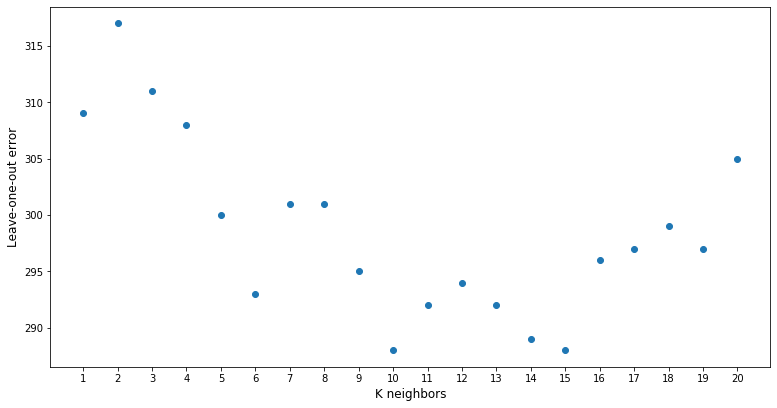

Best K: 10
Testing error for each digit:


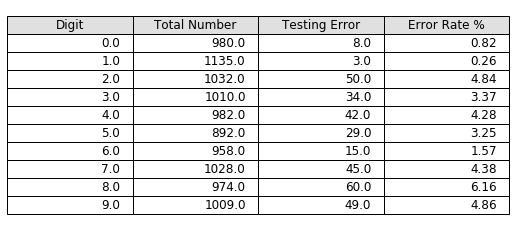

Query time: 738.4055378437042 

Downsample by a factor of 14
Leave-one-out error:


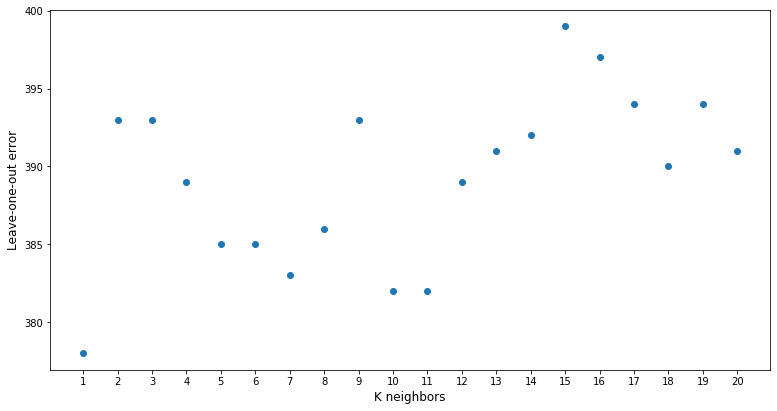

Best K: 1
Testing error for each digit:


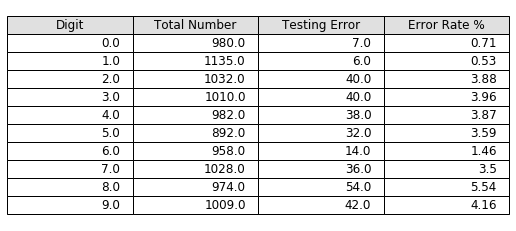

Query time: 742.3837950229645 



In [5]:
def downsample(sampleX,factor):
    for i in factor:
        new_x_Train=np.empty(shape=(sampleX.shape[0],sampleX.shape[1]//i)) # new train x
        for j in range(sampleX.shape[0]):
            for l in range(0,sampleX.shape[1],i):
                x=np.random.randint(i) # random select a index
                new_x_Train[j][l//i]=sampleX[j][l+x]
        
        print("Downsample by a factor of",i)
        start_time=time.time()
        knn_leave_one_out(new_x_Train,sampleY)
        end_time=time.time()
        print("Query time:",end_time-start_time,"\n")

print("Training sample size:",n)
factor=[2,4,8,14] # set downsample factor
downsample(sampleX,factor)

These plots show some KNN leave-one-out experiments for different downsamples. Each figure shows the leave-one-out error with values of K neighbors from 1 to 20 for all digits in a downsample factor and find the best value of K. X-axis is the value of K, y-axis is the leave-one-error corresponding to the value of K. Each table shows the test result of a KNN leave-one-out approach with best value of K. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100. The query time is the time to classify every new test data, recording during the knn_leave_one_out function.

COMMENTS:
Based on our choice of factor n ( 2,4,8,14 ), the best K is 1 when n is 2 or 4 or 14. So under this condition, we get same testing results. While n is 8, the best K is 10. Compared with K=10, the testing results for K=1 is better, which has lower error rate for most digits. When it comes to query time, n=2 has the longest query time which is 748.3124120235443, and n=4 has the shortest query time which is 734.8384160995483. So considering error rates  and query time, factor n=4 is the best choice.

---
iv) Implement a function that smart downsamples the image by binning nearby pixels.
- Set smart downsample factor
- Reshape sample data into n * 28 * 28 images, 
- For each image, sum every factor * factor small matrix to bin down to a (28/factor) * (28/factor) image
- Generate new testing data
- Run KNN leave-one-out experiment for each factor

Training sample size: 500
Smart downsampler of factor 2
Leave-one-out error:


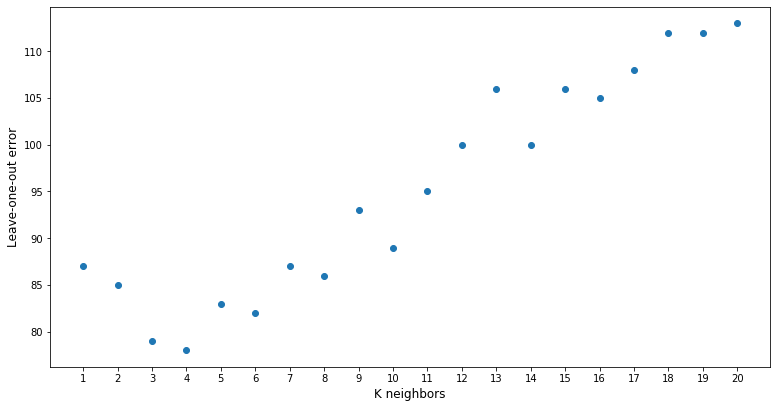

Best K: 4
Testing error for each digit:


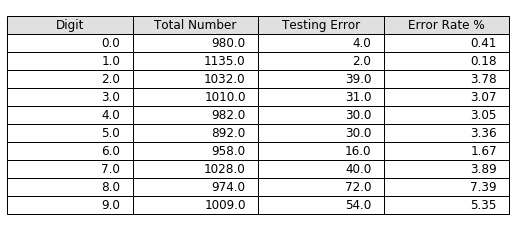

Query time: 754.2045669555664 

Smart downsampler of factor 4
Leave-one-out error:


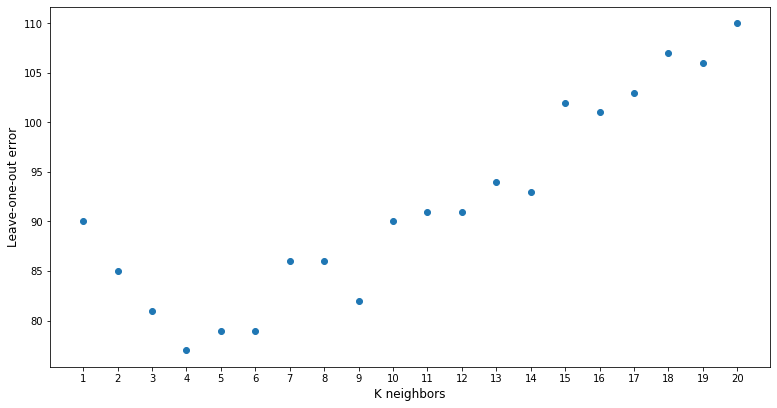

Best K: 4
Testing error for each digit:


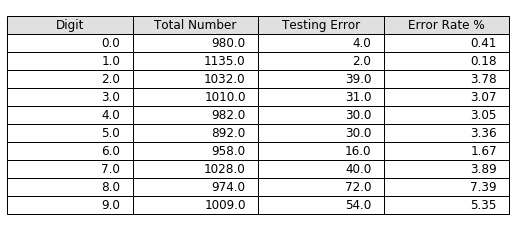

Query time: 738.6281089782715 

Smart downsampler of factor 7
Leave-one-out error:


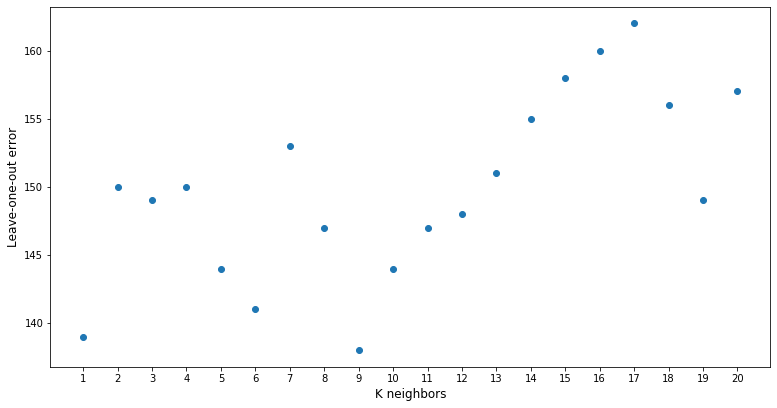

Best K: 9
Testing error for each digit:


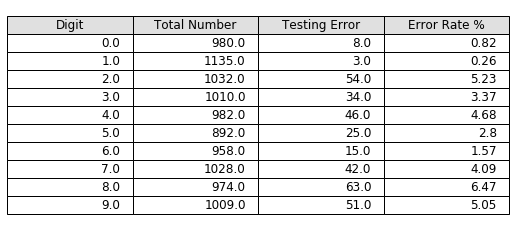

Query time: 729.305948972702 

Smart downsampler of factor 14
Leave-one-out error:


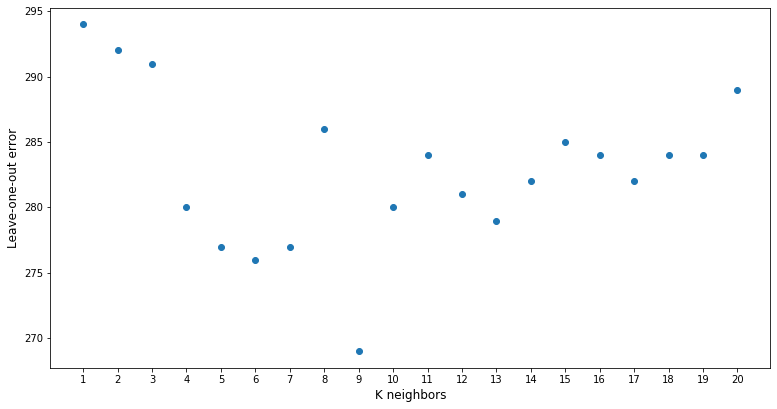

Best K: 9
Testing error for each digit:


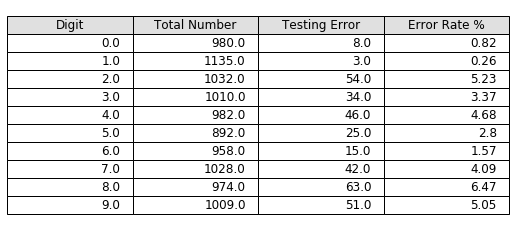

Query time: 728.169704914093 



In [6]:
def smart_downsample(sampleX,factor):
    sam_test_X=sampleX.reshape((n,28,28)) # reshape one long vector to 28*28 image for n samples
    for f in factor:
        news_x_train=np.empty(shape=(sam_test_X.shape[0],(28//f)*(28//f))) # new a matrix (28/factor)*(28/factor)
        for r in range(sam_test_X.shape[0]):
            for i in range(0,28//f):
                for j in range(0,28//f):
                    news_x_train[r,i*(28//f)+j]=np.sum(sam_test_X[r,f*i:f*(i+1),f*j:f*(j+1)]) # sum of a factor*factor matrix
        #print(new_x_train)
        print("Smart downsampler of factor",f)
        start_time=time.time()
        knn_leave_one_out(news_x_train,sampleY)
        end_time=time.time()
        print("Query time:",end_time-start_time,"\n")
    
print("Training sample size:",n)   
factor=[2,4,7,14] # set smart downsample factor
smart_downsample(sampleX,factor)

These plots show some KNN leave-one-out experiments for different smart downsamples. Each figure shows the leave-one-out error with values of K neighbors from 1 to 20 for all digits in a downsample factor and find the best value of K. X-axis is the value of K, y-axis is the leave-one-error corresponding to the value of K. Each table shows the test result of a KNN leave-one-out approach with best value of K. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100. The query time is the time to classify every new test data, recording during the knn_leave_one_out function.

COMMENTS: As the factor of smart downsamples increasing, the testing error has an increasing trend, and the query time  decreases, though there is no testing error difference when n is 2 or 4 and when n is 7 or 14. When n is 2 or 4, the best K is 4, with which to do prediction, the error for every digit has shown in table and the total prediction error rate is 3.18%. When n is 7 or 14, the best K is 9, with which to do prediction, the total prediction error rate is 3.41% which is higher. Considering error rate and query time, n=4 is the best one in all 4 factors to do smart downsample.  

---
v) Run  smart downsample at factor of 28, which reduces each image down to 1 pixel.

Training sample size: 500
Smart downsampler of factor 28
Leave-one-out error:


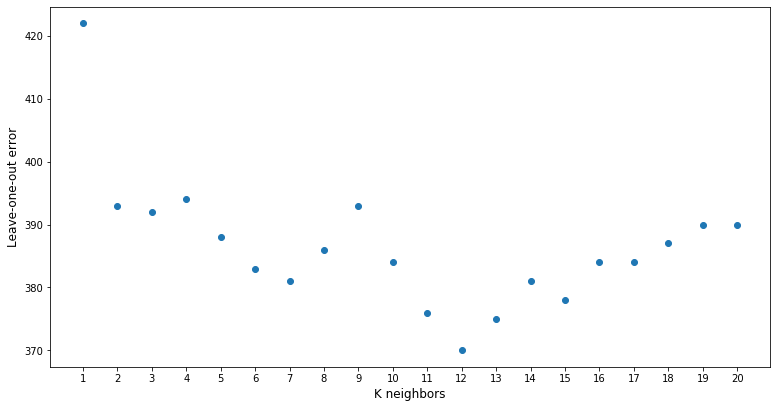

Best K: 12
Testing error for each digit:


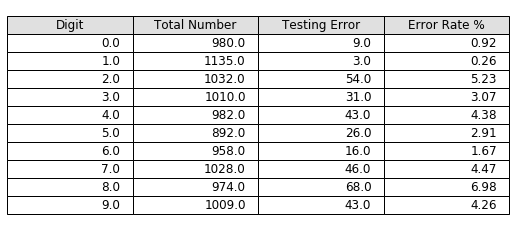

Query time: 728.8982329368591 



In [7]:
print("Training sample size:",n)
factor=[28] # set smart downsample factor
smart_downsample(sampleX,factor)

These plots show some KNN leave-one-out experiments for smart downsamples at factor of 28. Each figure shows the leave-one-out error with values of K neighbors from 1 to 20 for all digits in a downsample factor and find the best value of K. X-axis is the value of K, y-axis is the leave-one-error corresponding to the value of K. The table shows the test result of a KNN leave-one-out approach with best value of K. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100. The query time is the time to classify every new test data, recording during the knn_leave_one_out function.


COMMENTS: When the factor of smart downsample comes to 28, the best K is 12, with which the total prediction error rate is 3.39% and the query time is 728.8982329368591. Compared with the comments we get in question (iv), this output  is not as we imaged that total prediction error rate increases and query time decreases as n increases.

---
vi) Develop a feature transformation method that we use with the KNN leave-one-out experiment. After doing a little research of our own, we decide to use PCA (Principal Component Analysis) develop a feature transformation method. PCA reduces the dimensionality of a data set consisting of a large number of interrelated variables while retaining as much as possible of the variation present in the data set. The whole process of obtaining principle components from a training dataset can be simplified in six parts:
 - Take the whole dataset consisting of d+1 dimensions and ignore the labels such that our new dataset becomes d dimensional.
 - Compute the mean for every dimension of the whole dataset.
 - Compute the covariance matrix of the whole dataset.
 - Compute eigenvectors and the corresponding eigenvalues.
 - Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d × k dimensional matrix W.
 - Use this d × k eigenvector matrix to transform the samples onto the new subspace.

This method is referred from "The Mathematics Behind Principal Component Analysis". Here, we use sklearn to implement PCA:
 - Set the components with different factors
 - Fit the original training dataset
 - Transform into new traning dataset with the setting components
 - Use with the KNN leave-one-out experiment

Sample size: 500
PCA downsampler of component 2
Leave-one-out error:


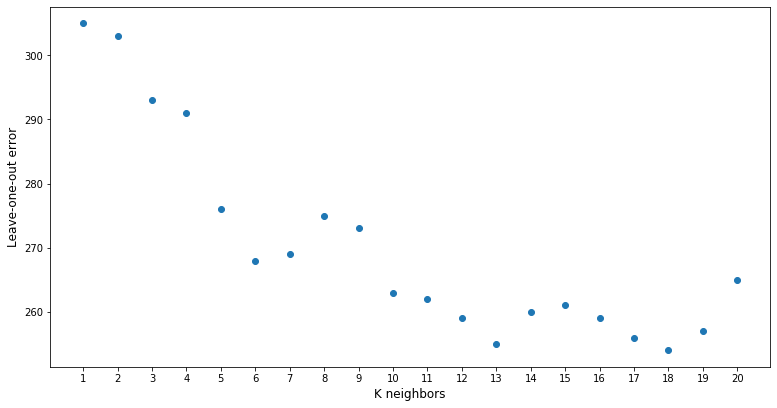

Best K: 18
Testing error for each digit:


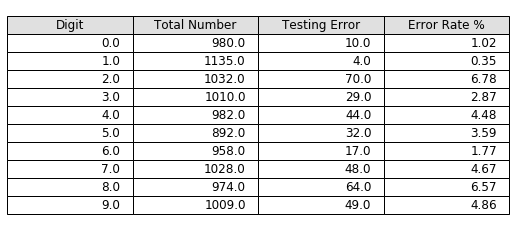

Query time: 732.5669550895691 

PCA downsampler of component 4
Leave-one-out error:


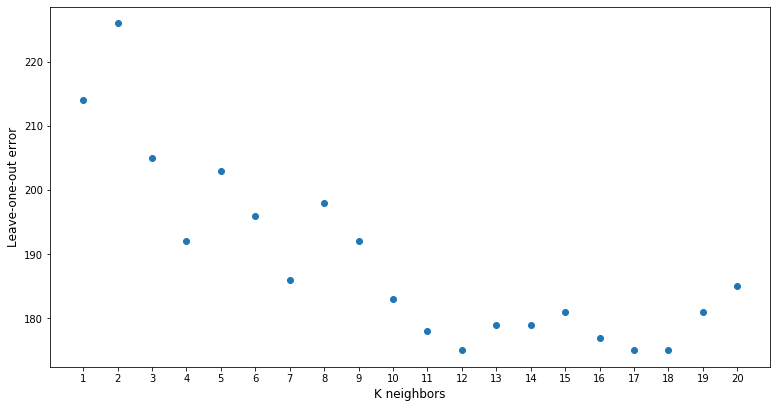

Best K: 12
Testing error for each digit:


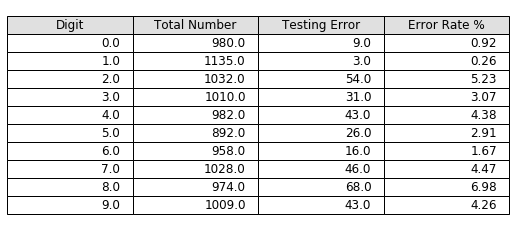

Query time: 735.110002040863 

PCA downsampler of component 8
Leave-one-out error:


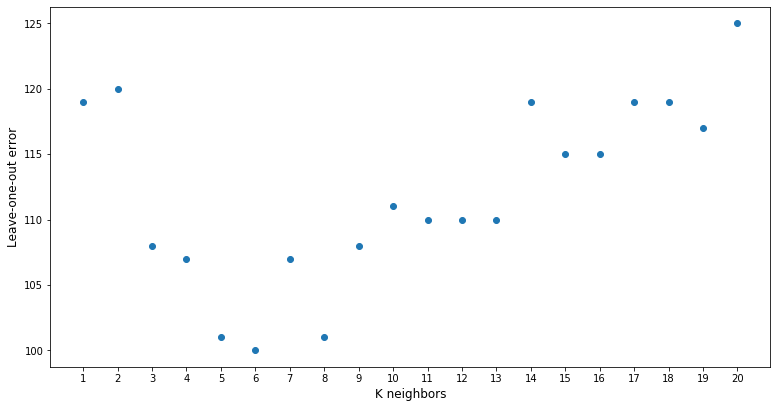

Best K: 6
Testing error for each digit:


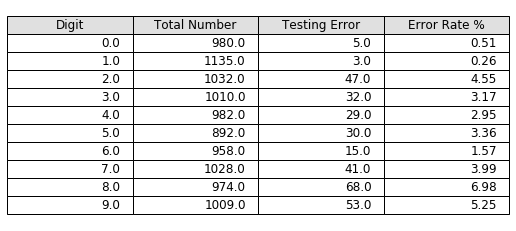

Query time: 740.0412039756775 

PCA downsampler of component 12
Leave-one-out error:


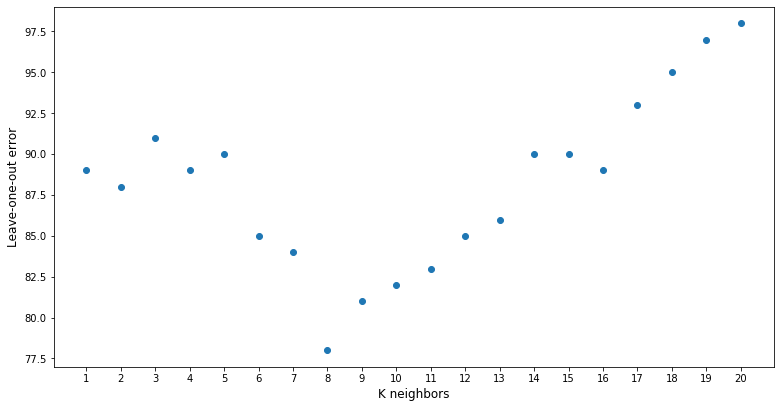

Best K: 8
Testing error for each digit:


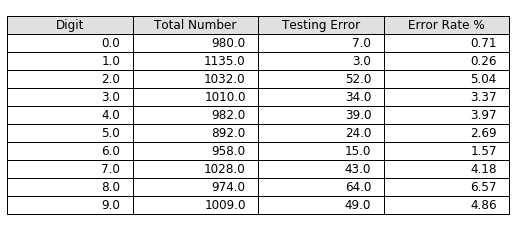

Query time: 738.3945159912109 



In [8]:
def pca_downsample(sampleX,factor):
    for f in factor:
        pca = PCA(n_components=f)
        pca.fit(sampleX)
        X_pca=pca.transform(sampleX)
        print("PCA downsampler of component",f)
        start_time=time.time()
        knn_leave_one_out(X_pca,sampleY)
        end_time=time.time()
        print("Query time:",end_time-start_time,"\n")
    
print("Sample size:",n)   
factor=[2,4,8,12] # PCA downsample factor
pca_downsample(sampleX,factor)

These plots show some KNN leave-one-out experiments for PCA downsamples at different factors. Each figure shows the leave-one-out error with values of K neighbors from 1 to 20 for all digits in a downsample factor and find the best value of K. X-axis is the value of K, y-axis is the leave-one-error corresponding to the value of K. Each table shows the test result of a KNN leave-one-out approach with best value of K. The first column is each digit, the second column is the number of occurrences of each digit in the test data, the third column is the number of testing error, and the last column is the testing error rate which is (Testing Error)/(Total Number)*100. The query time is the time to classify every new test data, recording during the knn_leave_one_out function.

COMMENTS: With different factors of PCA downsample n, we have different error rates and query time. When n is 2, query time is 732.5669550895691 and total error rate is 3.67%. When n is 4, query time is 735.110002040863 and total error rate is 3.39%.  When n is 8, query time is 740.0412039756775 and total error rate is 3.23%.  When n is 12, query time is 738.3945159912109 and total error rate is 3.30%. Considering the trade-off between query time and error rates, with PCA downsample, it seems that the best choice of factors in our test is n=8. Though the query time is the highest, the prediction accuracy is the best, in addition the extra overhead of query time is not too much when compared with other value of factors.  